# Import and Install Neccesary Libraries

In [ ]:
pip install -q seaborn

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint

 # Getting Dataset




In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
df = pd.read_excel('/content/gdrive/My Drive/TI206_AI/AI Project/Regression - Score Prediction/aspdbantul2.xlsx')

In [ ]:
df.head()

,Username,jumlah,BIND,MTK,BING,IPA,Rata-Rata,Median,Rank Kab
0,p040200013001,286.67000,67.5,86.67,72.5,60.00000,71.667500,70.000000,336
1,p040200013002,317.50000,75.0,80.00,92.5,70.00000,79.375000,77.500000,97
2,p040200013003,306.66667,72.5,90.00,77.5,66.66667,76.666668,75.000000,163
3,p040200013004,254.16667,72.5,40.00,85.0,56.66667,63.541668,64.583335,891
4,p040200013005,265.83000,77.5,53.33,75.0,60.00000,66.457500,67.500000,645


# Clean Data

In [ ]:
df.isna().sum()

Username     0
jumlah       0
BIND         0
MTK          0
BING         0
IPA          0
Rata-Rata    0
Median       0
Rank Kab     0
dtype: int64

In [ ]:
df = df.drop(columns=['Username','Rank Kab'])

In [ ]:
df.tail()

,jumlah,BIND,MTK,BING,IPA,Rata-Rata,Median
9995,87.50333,25.0,16.67,22.5,23.33333,21.875833,22.916665
9996,105.83333,22.5,10.00,30.0,43.33333,26.458333,26.250000
9997,95.00000,40.0,10.00,25.0,20.00000,23.750000,22.500000
9998,96.66667,20.0,20.00,20.0,36.66667,24.166667,20.000000
9999,154.17000,75.0,16.67,32.5,30.00000,38.542500,31.250000


# Split Data Train - Test

In [ ]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

# Inspect Data

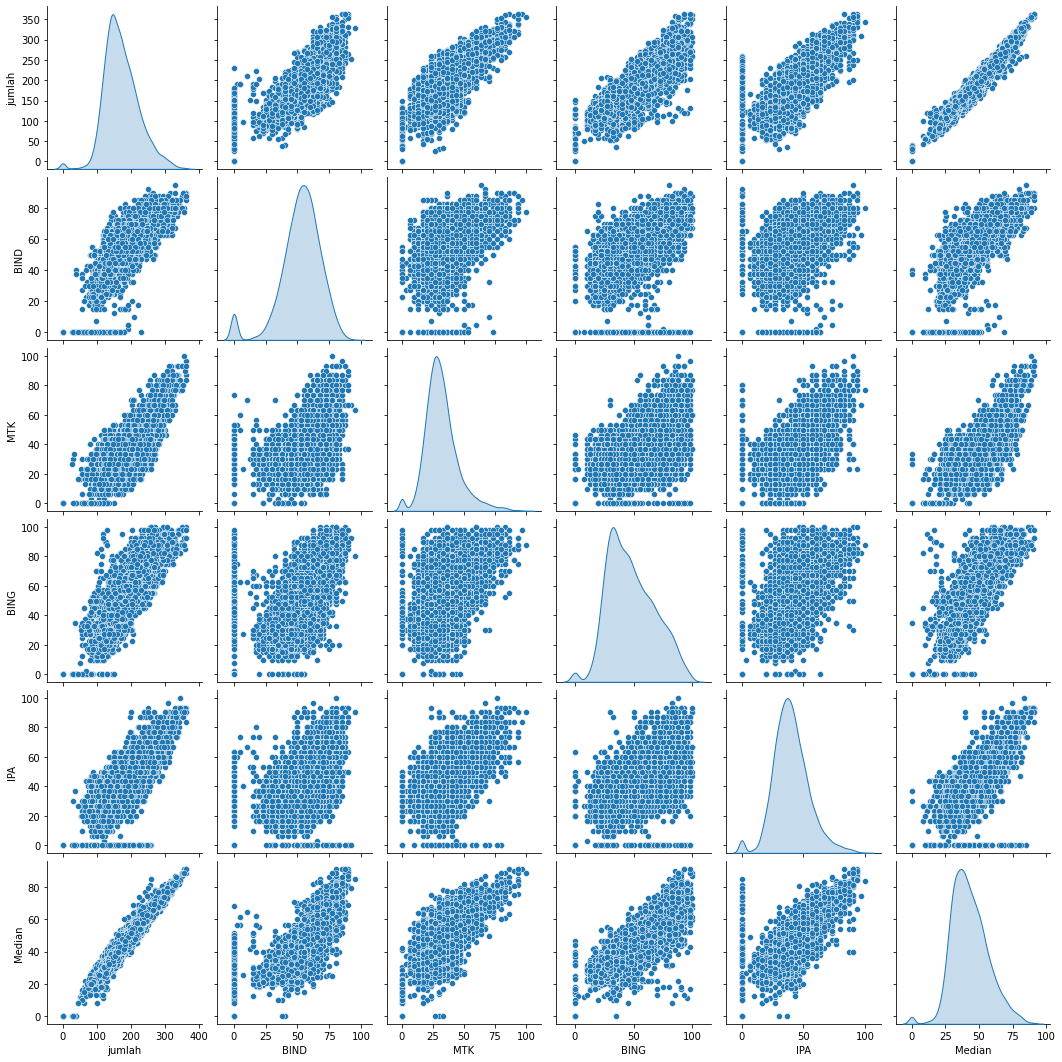

In [ ]:
sns.pairplot(train_dataset[['jumlah', 'BIND', 'MTK', 'BING', 'IPA', 'Median']], diag_kind='kde')


In [ ]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
jumlah,8000.0,172.018540,50.627857,0.0,138.3300,165.8300,201.67000,363.3300
BIND,8000.0,52.459375,15.910992,0.0,45.0000,55.0000,62.50000,95.0000
MTK,8000.0,31.751249,13.511553,0.0,23.3300,30.0000,36.67000,100.0000
BING,8000.0,47.857500,19.822203,0.0,32.5000,45.0000,62.50000,100.0000
IPA,8000.0,39.950417,14.339618,0.0,30.0000,40.0000,46.66667,100.0000
Rata-Rata,8000.0,43.004635,12.656964,0.0,34.5825,41.4575,50.41750,90.8325
Median,8000.0,43.033091,13.476554,0.0,33.3350,41.6650,51.25000,91.2500


# Split Features from Labels

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('jumlah')
test_labels = test_features.pop('jumlah')

# Normalization

In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
jumlah,172.018540,50.627857
BIND,52.459375,15.910992
MTK,31.751249,13.511553
BING,47.857500,19.822203
IPA,39.950417,14.339618
Rata-Rata,43.004635,12.656964
Median,43.033091,13.476554


# Normalization Layer

In [ ]:
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[52.459 31.751 47.858 39.95  43.005 43.033]]


In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[57.5  33.33 55.   53.33 49.79 54.17]]

Normalized: [[0.32 0.12 0.36 0.93 0.54 0.83]]


# BAHASA INDONESIA

This is still Linear Regression with only 1 variable. Now these code create feature

In [ ]:
bindo = np.array(train_features['BIND'])

bindo_normalizer = layers.Normalization(input_shape=[1,], axis = None)
bindo_normalizer.adapt(bindo)

Build Keras Sequential Model

In [ ]:
bindo_model = tf.keras.Sequential([
    bindo_normalizer,
    layers.Dense(units=1)
])

bindo_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [ ]:
bindo_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Executing training for 100 epochs

In [ ]:
%%time
history_bindo = bindo_model.fit(
    train_features['BIND'],
    train_labels,
    epochs=100,
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 29.6 s, sys: 1.93 s, total: 31.5 s
Wall time: 41.3 s


In [ ]:
hist_bindo = pd.DataFrame(history_bindo.history)
hist_bindo['epoch'] = history_bindo.epoch
hist_bindo.tail()

,loss,val_loss,epoch
95,24.252005,23.457848,95
96,24.256275,23.457491,96
97,24.256020,23.467207,97
98,24.253620,23.469168,98
99,24.260977,23.463940,99


Make Function for Loss History

In [ ]:
def plot_loss(history):
  plt.figure(figsize=[10,10])
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlim([0, 100])
  plt.ylim([0, 40])

  plt.xlabel('Epoch')
  plt.ylabel('Error [jumlah]')
  plt.legend()
  plt.grid(True)

Collect the test set result

In [ ]:
test_results_lg = {}

test_results_lg['bindo_model'] = bindo_model.evaluate(
    test_features['BIND'],
    test_labels, verbose=0)

View model's prediction

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = bindo_model.predict(x)

In [ ]:
def plot_prediction_bindo(x, y):
  plt.figure(figsize=[10,10])
  plt.scatter(train_features['BIND'], train_labels, label='data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlim([0,100])
  plt.ylim([0,400])
  plt.xlabel('BIND')
  plt.ylabel('jumlah')
  plt.legend()

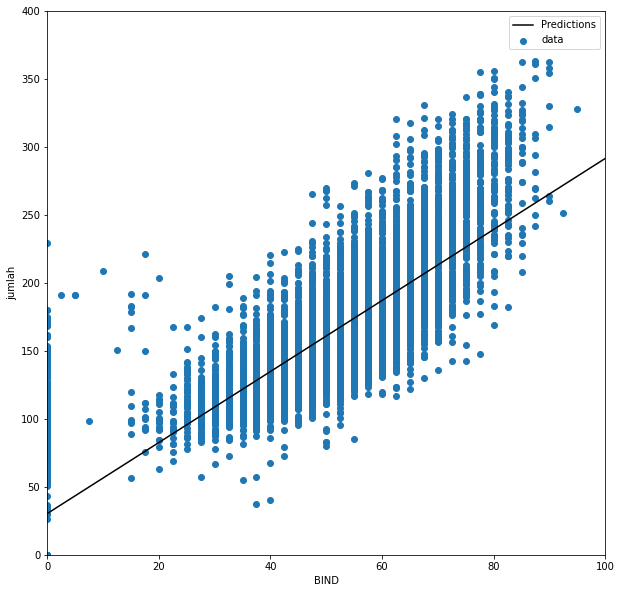

In [ ]:
plot_prediction_bindo(x,y)

Regression with Deep Neural Network

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
dnn_bindo_model = build_and_compile_model(bindo_normalizer)
dnn_bindo_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_9 (Dense)             (None, 64)                128       
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [ ]:
%%time
history_dnn_bindo = dnn_bindo_model.fit(
    #plt.figure(figsize=[10,10]),
    train_features['BIND'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100,
    #callbacks=callbacks_list
    )

CPU times: user 41.6 s, sys: 3.19 s, total: 44.8 s
Wall time: 35.1 s


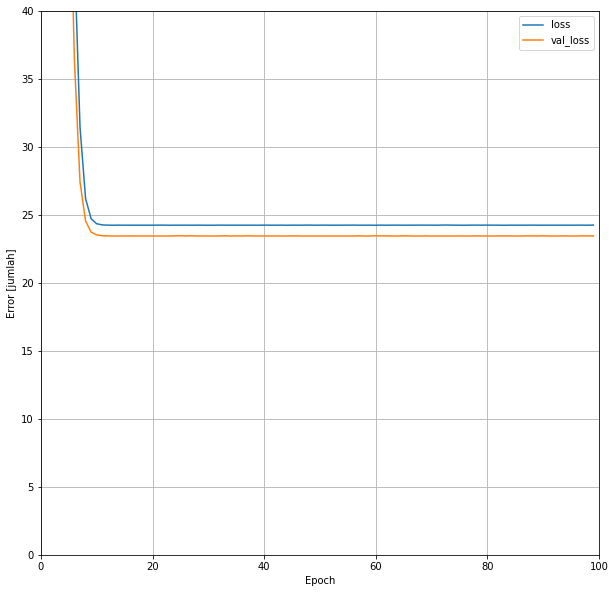

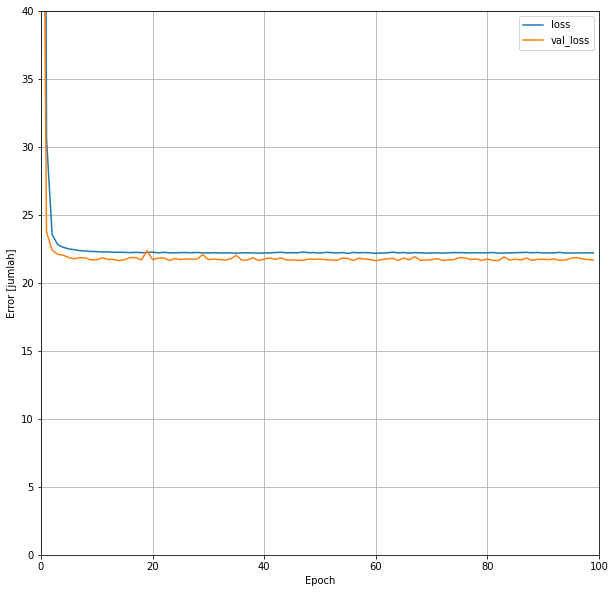

In [ ]:
plot_loss(history_bindo)
plot_loss(history_dnn_bindo)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = dnn_bindo_model.predict(x)

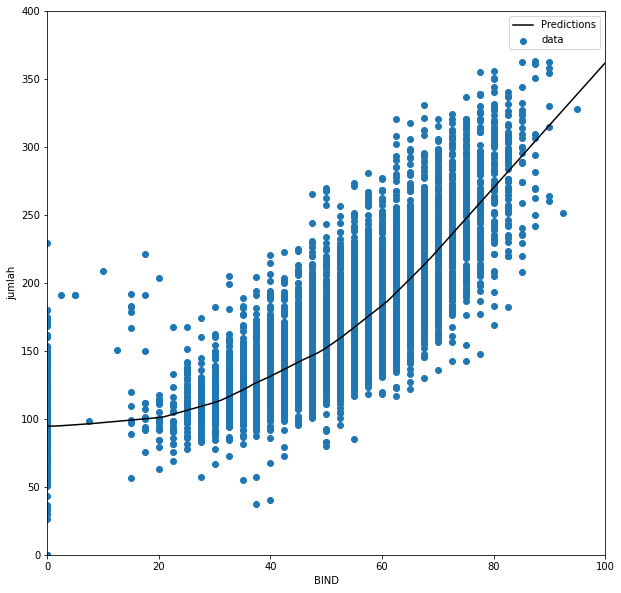

In [ ]:
# Prediction DNN
plot_prediction_bindo(x,y)

In [ ]:
test_results_dnn = {}

test_results_dnn['dnn_bindo_model'] = dnn_bindo_model.evaluate(
    test_features['BIND'], test_labels,
    verbose=0)

Check Performance

In [ ]:
display_test_results_lg = pd.DataFrame(test_results_lg, index=['Mean absolute error [jumlah]']).T
display_test_results_lg

,Mean absolute error [jumlah]
bindo_model,24.167099


In [ ]:
display_test_results_dnn = pd.DataFrame(test_results_dnn, index=['Mean absolute error [jumlah]']).T
display_test_results_dnn

,Mean absolute error [jumlah]
dnn_bindo_model,22.273125


# MATEMATIKA

This is still Linear Regression with only 1 variable. Now these code create feature

In [ ]:
math = np.array(train_features['MTK'])

math_normalizer = layers.Normalization(input_shape=[1,], axis = None)
math_normalizer.adapt(math)

Build Keras Sequential Model

In [ ]:
math_model = tf.keras.Sequential([
    math_normalizer,
    layers.Dense(units=1)
])

math_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_12 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [ ]:
math_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Executing training for 100 epochs

In [ ]:
%%time
history_math = math_model.fit(
    train_features['MTK'],
    train_labels,
    epochs=100,
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 34.8 s, sys: 1.97 s, total: 36.7 s
Wall time: 36.3 s


In [ ]:
hist_math = pd.DataFrame(history_math.history)
hist_math['epoch'] = history_math.epoch
hist_math.tail()

,loss,val_loss,epoch
95,26.736155,26.965832,95
96,26.723108,26.951221,96
97,26.728151,26.942476,97
98,26.727606,26.981247,98
99,26.728779,26.946711,99


Collect the test set result

In [ ]:
test_results_lg['math_model'] = math_model.evaluate(
    test_features['MTK'],
    test_labels, verbose=0)

View model's prediction

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = math_model.predict(x)

In [ ]:
def plot_prediction_math(x, y):
  plt.figure(figsize=[10,10])
  plt.scatter(train_features['MTK'], train_labels, label='data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlim([0,100])
  plt.ylim([0,400])
  plt.xlabel('MTK')
  plt.ylabel('jumlah')
  plt.legend()

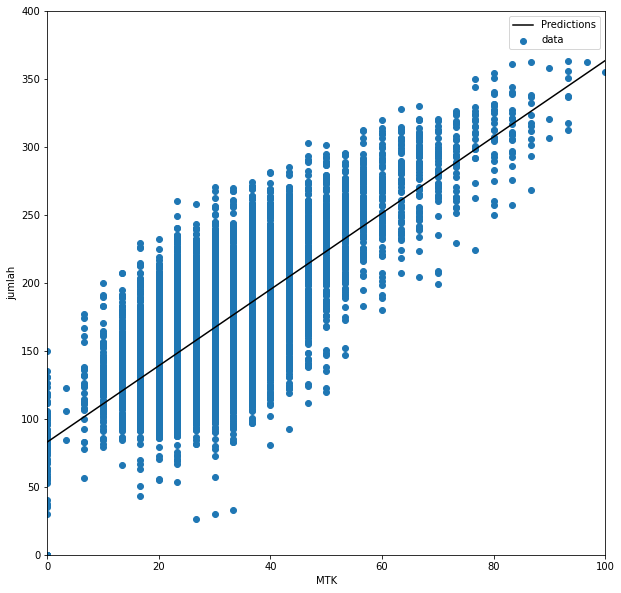

In [ ]:
plot_prediction_math(x,y)

DNN model with `MTK` as feature

In [ ]:
dnn_math_model = build_and_compile_model(math_normalizer)
dnn_math_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_13 (Dense)            (None, 64)                128       
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [ ]:
%%time
history_dnn_math = dnn_math_model.fit(
    #plt.figure(figsize=[10,10]),
    train_features['MTK'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100,
    #callbacks=callbacks_list
    )

CPU times: user 42.3 s, sys: 3.06 s, total: 45.3 s
Wall time: 37.4 s


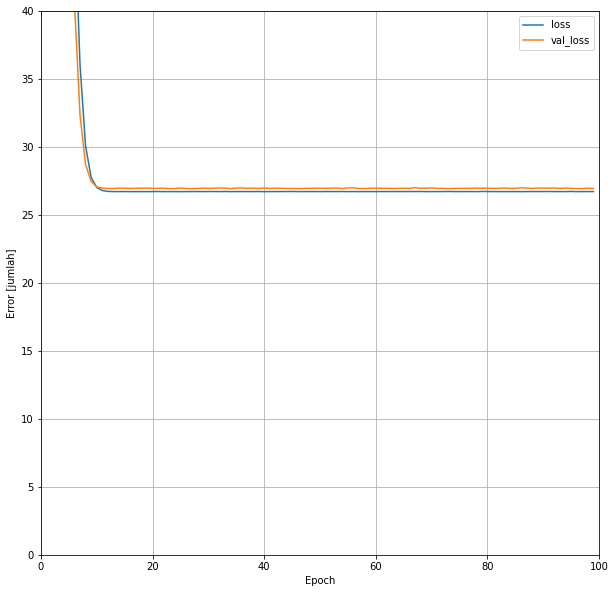

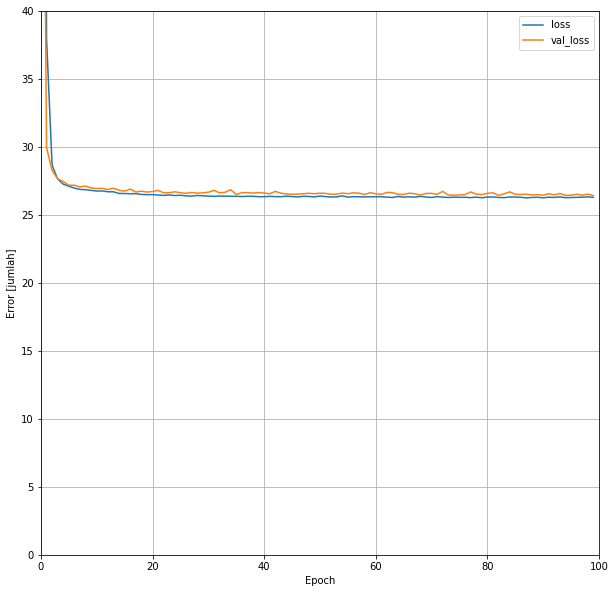

In [ ]:
plot_loss(history_math)
plot_loss(history_dnn_math)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = dnn_math_model.predict(x)

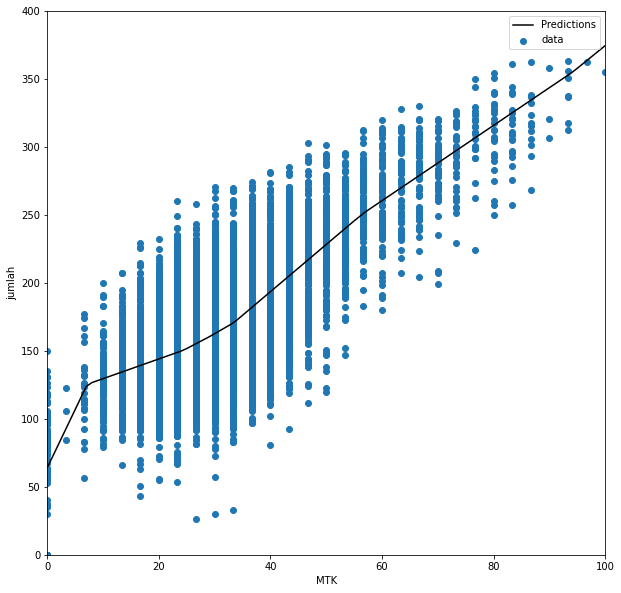

In [ ]:
# Prediction DNN
plot_prediction_math(x,y)

In [ ]:
test_results_dnn['dnn_math_model'] = dnn_math_model.evaluate(
    test_features['MTK'], test_labels,
    verbose=0)

Check Performance

In [ ]:
display_test_results_lg = pd.DataFrame(test_results_lg, index=['Mean absolute error [jumlah]']).T
display_test_results_lg

,Mean absolute error [jumlah]
bindo_model,24.167099
math_model,26.017153


In [ ]:
display_test_results_dnn = pd.DataFrame(test_results_dnn, index=['Mean absolute error [jumlah]']).T
display_test_results_dnn

,Mean absolute error [jumlah]
dnn_bindo_model,22.273125
dnn_math_model,25.781689


# BAHASA INGGRIS

This is still Linear Regression with only 1 variable. Now these code create feature

In [ ]:
eng = np.array(train_features['BING'])

eng_normalizer = layers.Normalization(input_shape=[1,], axis = None)
eng_normalizer.adapt(eng)

Build Keras Sequential Model

In [ ]:
eng_model = tf.keras.Sequential([
    eng_normalizer,
    layers.Dense(units=1)
])

eng_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_16 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [ ]:
eng_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Executing training for 100 epochs

In [ ]:
%%time
history_eng = eng_model.fit(
    train_features['BING'],
    train_labels,
    epochs=100,
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 35.5 s, sys: 2.08 s, total: 37.6 s
Wall time: 41.3 s


In [ ]:
hist_eng = pd.DataFrame(history_eng.history)
hist_eng['epoch'] = history_eng.epoch
hist_eng.tail()

,loss,val_loss,epoch
95,19.536118,18.247736,95
96,19.529522,18.258425,96
97,19.535412,18.226517,97
98,19.528763,18.298710,98
99,19.536016,18.246454,99


Collect the test set result

In [ ]:
test_results_lg['eng_model'] = eng_model.evaluate(
    test_features['BING'],
    test_labels, verbose=0)

View model's prediction

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = eng_model.predict(x)

In [ ]:
def plot_prediction_eng(x, y):
  plt.figure(figsize=[10,10])
  plt.scatter(train_features['BING'], train_labels, label='data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlim([0,100])
  plt.ylim([0,400])
  plt.xlabel('BING')
  plt.ylabel('jumlah')
  plt.legend()

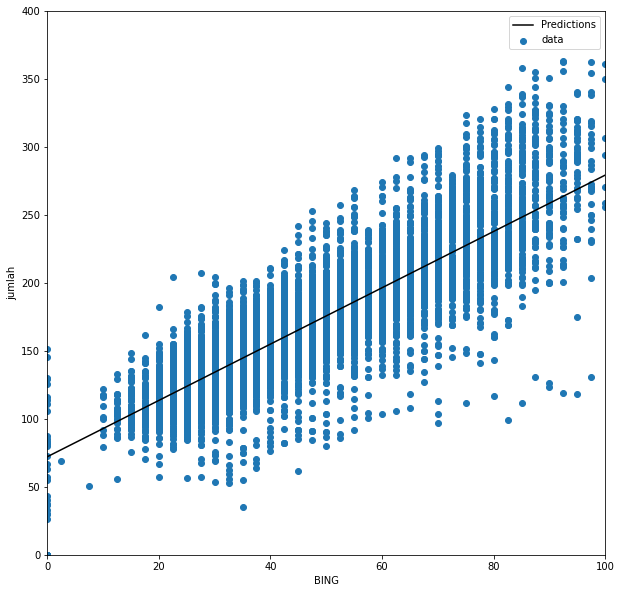

In [ ]:
plot_prediction_eng(x,y)

DNN model with `BING` as feature

In [ ]:
dnn_eng_model = build_and_compile_model(eng_normalizer)
dnn_eng_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_17 (Dense)            (None, 64)                128       
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [ ]:
%%time
history_dnn_eng = dnn_eng_model.fit(
    #plt.figure(figsize=[10,10]),
    train_features['BING'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100,
    #callbacks=callbacks_list
    )

CPU times: user 50.3 s, sys: 2.93 s, total: 53.3 s
Wall time: 56.3 s


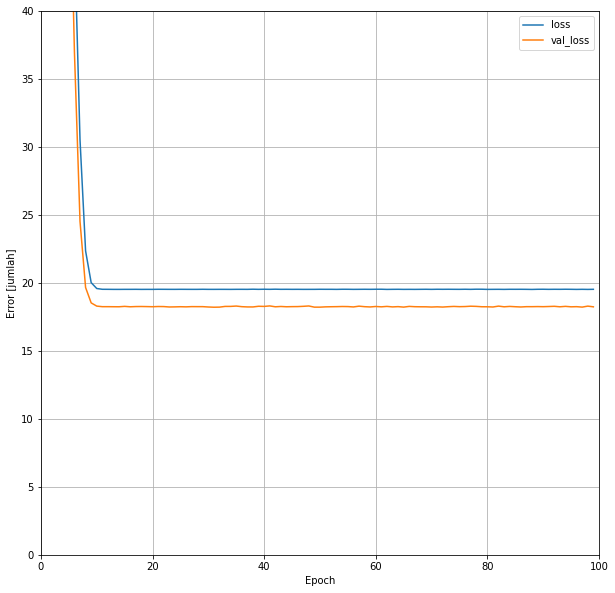

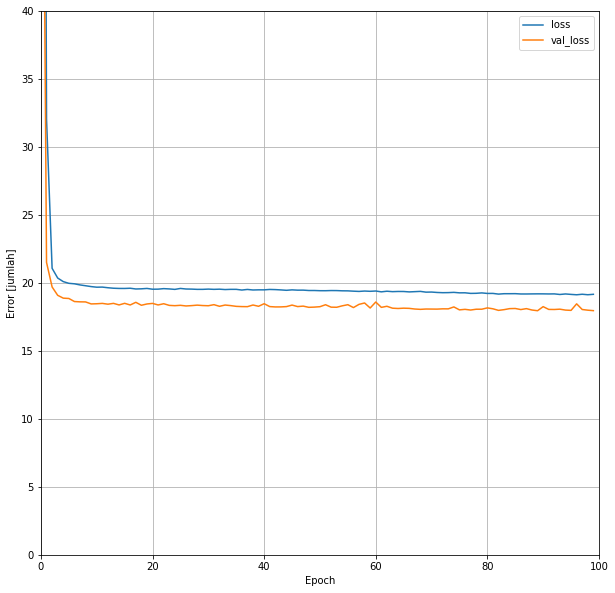

In [ ]:
plot_loss(history_eng)
plot_loss(history_dnn_eng)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = dnn_eng_model.predict(x)

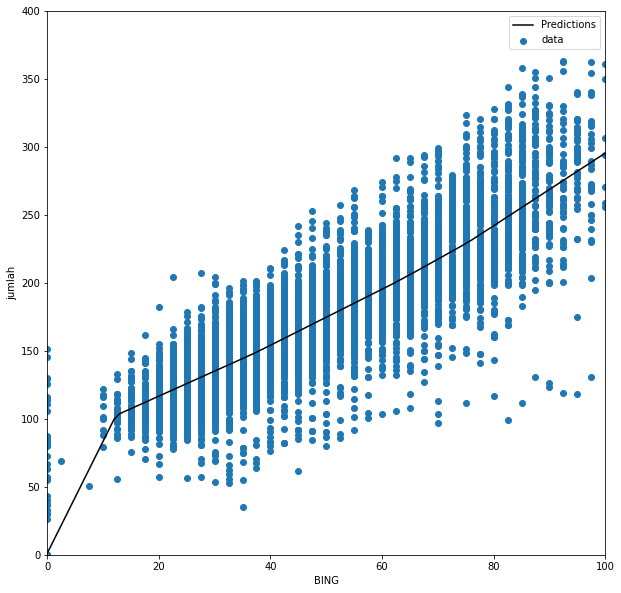

In [ ]:
# Prediction DNN
plot_prediction_eng(x,y)

In [ ]:
test_results_dnn['dnn_eng_model'] = dnn_eng_model.evaluate(
    test_features['BING'], test_labels,
    verbose=0)

Check Performance

In [ ]:
display_test_results_lg = pd.DataFrame(test_results_lg, index=['Mean absolute error [jumlah]']).T
display_test_results_lg

,Mean absolute error [jumlah]
bindo_model,24.167099
math_model,26.017153
eng_model,19.229675


In [ ]:
display_test_results_dnn = pd.DataFrame(test_results_dnn, index=['Mean absolute error [jumlah]']).T
display_test_results_dnn

,Mean absolute error [jumlah]
dnn_bindo_model,22.273125
dnn_math_model,25.781689
dnn_eng_model,18.763222


# IPA

This is still Linear Regression with only 1 variable. Now these code create feature

In [ ]:
science = np.array(train_features['IPA'])

science_normalizer = layers.Normalization(input_shape=[1,], axis = None)
science_normalizer.adapt(science)

Build Keras Sequential Model

In [ ]:
science_model = tf.keras.Sequential([
    science_normalizer,
    layers.Dense(units=1)
])

science_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_20 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [ ]:
science_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Executing training for 100 epochs

In [ ]:
%%time
history_science = science_model.fit(
    train_features['IPA'],
    train_labels,
    epochs=100,
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 43.4 s, sys: 2.22 s, total: 45.6 s
Wall time: 48.8 s


In [ ]:
hist_science = pd.DataFrame(history_science.history)
hist_science['epoch'] = history_science.epoch
hist_science.tail()

,loss,val_loss,epoch
95,24.749819,23.831675,95
96,24.755074,23.830551,96
97,24.747793,23.827183,97
98,24.755909,23.824680,98
99,24.750751,23.838839,99


Collect the test set result

In [ ]:
test_results_lg['science_model'] = science_model.evaluate(
    test_features['IPA'],
    test_labels, verbose=0)

View model's prediction

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = science_model.predict(x)

In [ ]:
def plot_prediction_science(x, y):
  plt.figure(figsize=[10,10])
  plt.scatter(train_features['IPA'], train_labels, label='data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlim([0,100])
  plt.ylim([0,400])
  plt.xlabel('IPA')
  plt.ylabel('jumlah')
  plt.legend()

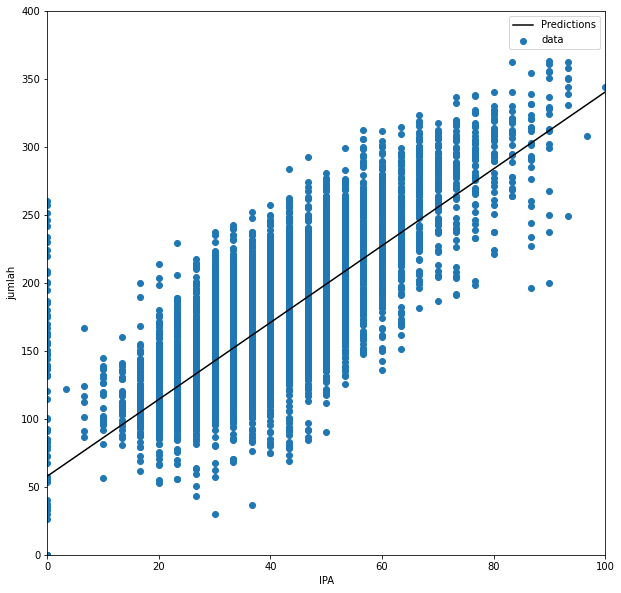

In [ ]:
plot_prediction_science(x,y)

DNN model with `MTK` as feature

In [ ]:
dnn_science_model = build_and_compile_model(science_normalizer)
dnn_science_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_21 (Dense)            (None, 64)                128       
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [ ]:
%%time
history_dnn_science = dnn_science_model.fit(
    #plt.figure(figsize=[10,10]),
    train_features['IPA'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100,
    #callbacks=callbacks_list
    )

CPU times: user 56.5 s, sys: 3.04 s, total: 59.5 s
Wall time: 1min 1s


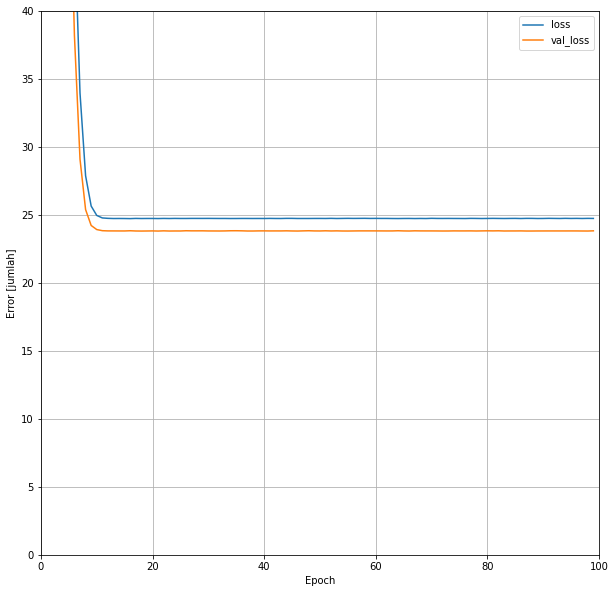

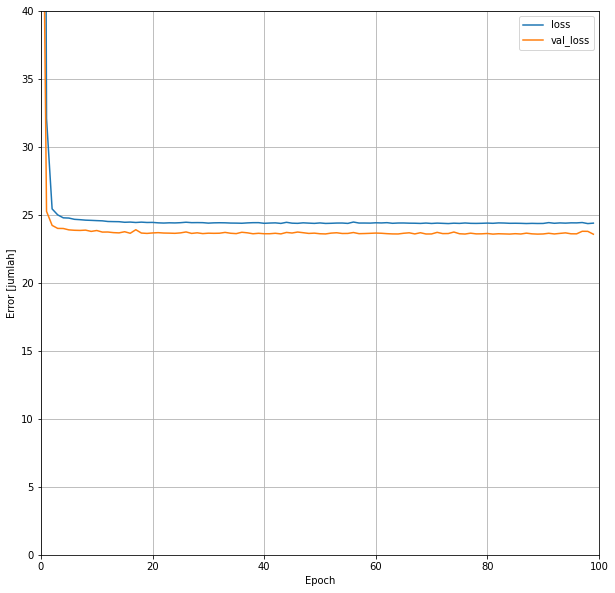

In [ ]:
plot_loss(history_science)
plot_loss(history_dnn_science)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = dnn_science_model.predict(x)

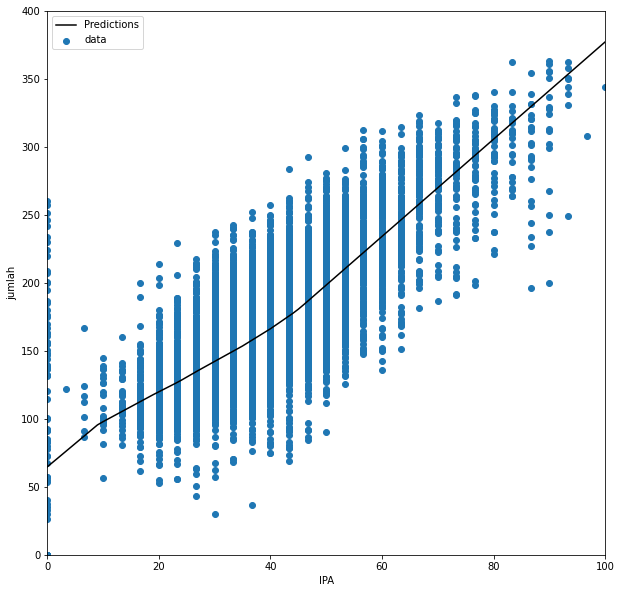

In [ ]:
# Prediction DNN
plot_prediction_science(x,y)

In [ ]:
test_results_dnn['dnn_science_model'] = dnn_science_model.evaluate(
    test_features['IPA'], test_labels,
    verbose=0)

Check Performance

In [ ]:
display_test_results_lg = pd.DataFrame(test_results_lg, index=['Mean absolute error [jumlah]']).T
display_test_results_lg

,Mean absolute error [jumlah]
bindo_model,24.167099
math_model,26.017153
eng_model,19.229675
science_model,24.045286


In [ ]:
display_test_results_dnn = pd.DataFrame(test_results_dnn, index=['Mean absolute error [jumlah]']).T
display_test_results_dnn

,Mean absolute error [jumlah]
dnn_bindo_model,22.273125
dnn_math_model,25.781689
dnn_eng_model,18.763222
dnn_science_model,23.631462


# Make Prediction

Define Function for display Test Prediction based on models with Plot

In [ ]:
def plot_test_predictions(model):
  a = plt.axes(aspect='equal')
  plt.scatter(test_labels, model)
  plt.xlabel('True Values [jumlah]')
  plt.ylabel('Predictions [jumlah]')
  lims = [0, 400]
  plt.xlim(lims)
  plt.ylim(lims)
  _ = plt.plot(lims, lims)

## Test Predict model one by one

### Bahasa Indonesia

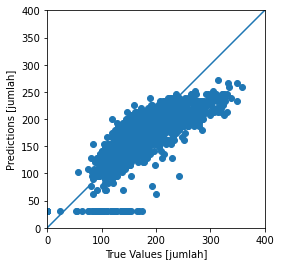

In [ ]:
test_predict_bindo = bindo_model.predict(test_features['BIND']).flatten()

plot_test_predictions(test_predict_bindo)

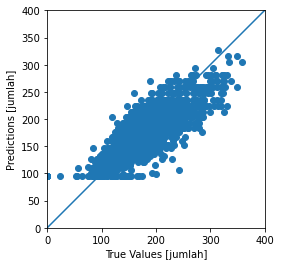

In [ ]:
test_predict_dnn_bindo = dnn_bindo_model.predict(test_features['BIND']).flatten()

plot_test_predictions(test_predict_dnn_bindo)

### Matematika

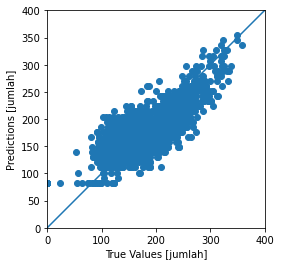

In [ ]:
test_predict_math = math_model.predict(test_features['MTK']).flatten()

plot_test_predictions(test_predict_math)

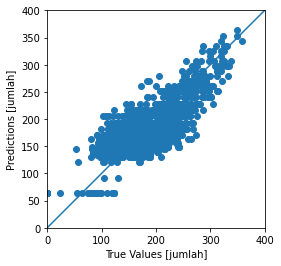

In [ ]:
test_predict_dnn_math = dnn_math_model.predict(test_features['MTK']).flatten()

plot_test_predictions(test_predict_dnn_math)

### Bahasa Inggris

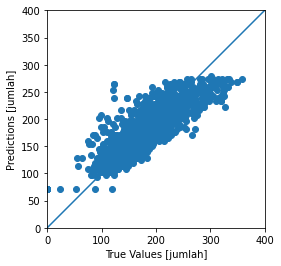

In [ ]:
test_predict_eng = eng_model.predict(test_features['BING']).flatten()

plot_test_predictions(test_predict_eng)

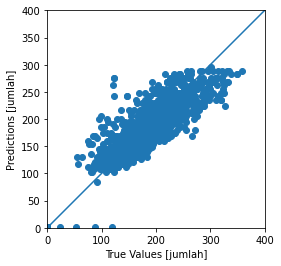

In [ ]:
test_predict_dnn_eng = dnn_eng_model.predict(test_features['BING']).flatten()

plot_test_predictions(test_predict_dnn_eng)

### IPA

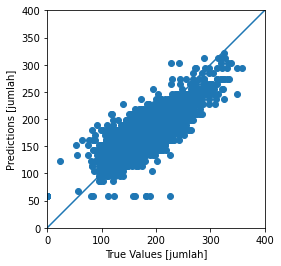

In [ ]:
test_predict_science = science_model.predict(test_features['IPA']).flatten()

plot_test_predictions(test_predict_science)

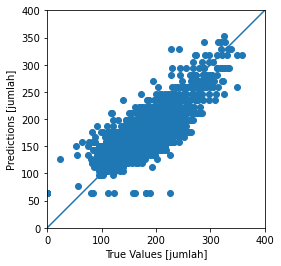

In [ ]:
test_predict_dnn_science = dnn_science_model.predict(test_features['IPA']).flatten()

plot_test_predictions(test_predict_dnn_science)

## Histogram Error Chart

Define Function for Histogram

In [ ]:
def histogram_error(model):
  error = model - test_labels
  plt.hist(error, bins=25)
  plt.xlabel('Prediction Error [jumlah]')
  _ = plt.ylabel('Count')

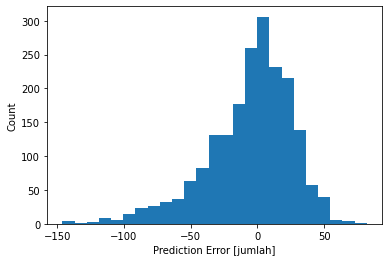

In [ ]:
histogram_error(test_predict_bindo)


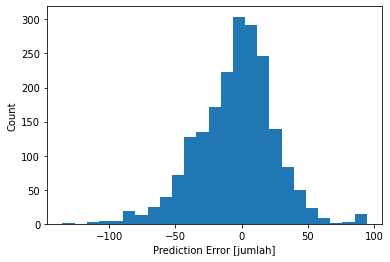

In [ ]:
histogram_error(test_predict_dnn_bindo)

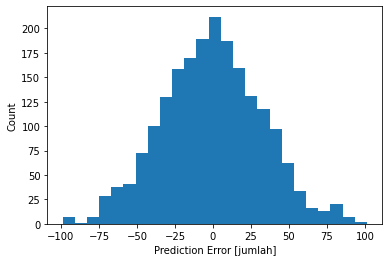

In [ ]:
histogram_error(test_predict_math)

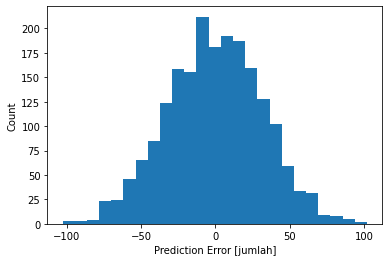

In [ ]:
histogram_error(test_predict_dnn_math)

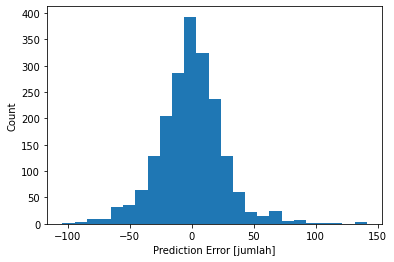

In [ ]:
histogram_error(test_predict_eng)

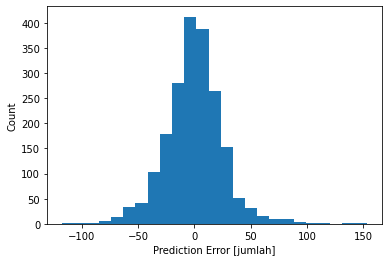

In [ ]:
histogram_error(test_predict_dnn_eng)

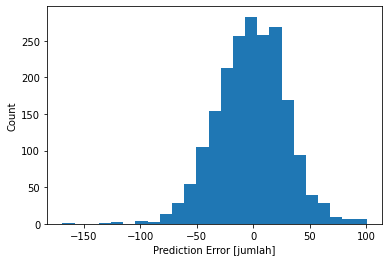

In [ ]:
histogram_error(test_predict_science)

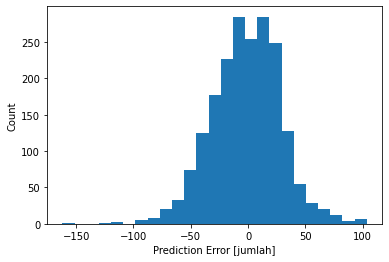

In [ ]:
histogram_error(test_predict_dnn_science)

In [ ]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [ ]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)